In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

In [2]:
df_jan = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet') 
df_feb = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')


lowercase the columns names

In [3]:
data = [df_jan, df_feb]
for df in data:
    df.columns = df.columns.str.lower().str.replace(' ', '_')

Merge the data of column february and january

In [4]:
df = pd.concat([df_jan, df_feb], ignore_index=True) # merge 
data.append(df) # In case if we wanted to apply changes on each dataframe alone.
df.head(5)

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [5]:
print('How many columns are there?')
print(df.shape[-1])

How many columns are there?
19


**Creating a duration vriable** Contain the duration of ride in minutes

In [6]:
def get_duration(df):
    """
    calculate the duration of the trip
    
    (drop date - pickup date) / convert the diffrence to minutes representations using pd.Timedelta
    
    """
    
    df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']) / pd.Timedelta(minutes=1)
    return df

df = get_duration(df)
df.head(2)

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.0,0.5,0.0,0.0,1.0,14.3,2.5,0.0,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.0,0.5,4.0,0.0,1.0,16.9,2.5,0.0,6.316667


In [7]:
print('the standard deviation of the trips duration in January?')
df_jan = get_duration(df_jan)
round(df_jan.duration.std(), 2)

the standard deviation of the trips duration in January?


42.59

**Checking the destribution of the data**

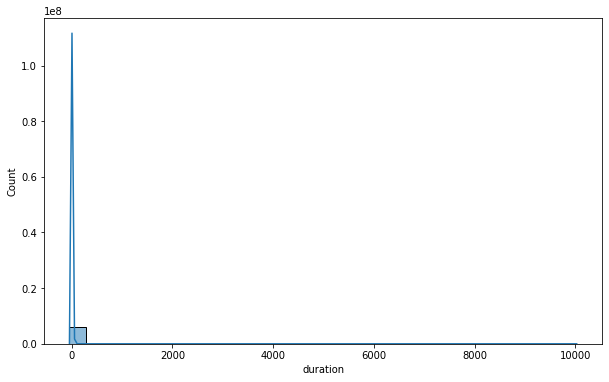

In [8]:
def plot_duration(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['duration'], bins=30, kde=True)
    plt.show()
plot_duration(df)

Looks like we have an extreme outliers. Let's detect them.

In [9]:
def describe_duration(df):
    """
    Applying simple pd.describe at duration
    percentiles parameter by default will print(25%, 50%, 75%) but we can add more!
    .apply(lambda x:f'{x:.2f}') --> this format the output from describe (5.980721e+06 -> 15.84) to be human readable
    
    better way you can use -> pd.set_option('display.float_format', lambda x: '%.2f' % x)
    """
    print(df.duration.describe(percentiles=[.25, .75, .90, .95, .99]).apply(lambda x:f'{x:.2f}'))
describe_duration(df)

count    5980721.00
mean          15.84
std           42.72
min          -43.62
25%            7.18
50%           11.65
75%           18.53
90%           28.20
95%           36.83
99%           58.03
max        10029.18
Name: duration, dtype: object


Now we can filter the data by removing the values above .99 percentile, below 0.1 to exclude the negatives and extremly high durations

In [10]:
p_99 = df['duration'].quantile(.99)
p_01 = df['duration'].quantile(.01)
df_filtered = df[(p_01 < df['duration']) & (p_99 > df['duration'])]
describe_duration(df_filtered)

count    5861031.00
mean          14.25
std            9.85
min            0.80
25%            7.27
50%           11.65
75%           18.33
90%           27.33
95%           34.65
99%           49.43
max           58.02
Name: duration, dtype: object


Sounds good! Let's check plot the distribution of df_filtered


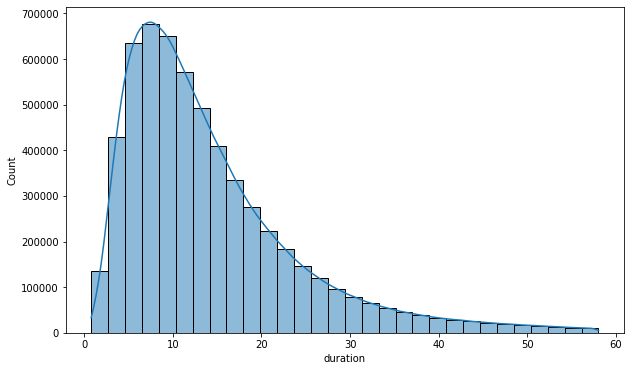

In [11]:
plot_duration(df_filtered)

now we can confidently go throught the modeling part\
I will use linear regression for simplicity

In [15]:
df_filtered.head(1)

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.0,0.5,0.0,0.0,1.0,14.3,2.5,0.0,8.433333


In [ ]:

def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    # Dict vectorizer as the name suggests converting the dict into vector. keeping the values only.
    dv = DictVectorizer(sparse=False)

    # transform the dicts into vectors using dv
    X_train = dv.fit_transform(dicts)

    # Train the model 
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Return the vectorizer and the trained model
    return dv, model